# Tutorial
I’m going to explore the practical usages of topic model using the Gensim Library, such as finding structures for unknown datasets, classifying unlabeled data as well as improving accuracy of supervised learning.

## Introduction
This tutorial will introduce you several practical ways of using topic models with **Gensim Library**. In this tutorial I mainly focus on 2 kinds of topic models: *Latent Semantic Indexing (LSI)* and *Latent Dirichlet Allocation (LDA)*. In different cases, topic models can have different functionalities. Throughout this tutorial, you will learn how to use topic models to find structure for unknown datasets, classifying unlabeled data as well as improving the accuracy of supervised learning. Besides, in order to have a better views to the results, this tutorial also introduces some data visualization methods for reviewing topic models. 

We will cover the following topics in this tutorial:
- [Installing the libraries](#Installing-the-libraries)
- [Processing text](#Processing-text)
- [Visualizing Topic models](#Visualizing-Topic-models)
- [Train Topic Models](#Train-Topic-Models)
    - [Training LSI model and visualizing](#Training-LSI-model-and-visualizing)
    - [Training LDA model and visualizing](#Training-LDA-model-and-visualizing)
    - [Comparation](#Comparation)
- [Finding structures of unknown text](#Finding-structures-of-unknown-text)
- [Classifying unlabeled data](#Classifying-unlabeled-data)
    - [Larger topic number](#Larger-topic-number)
    - [Larger dataset](#Larger-dataset)
    - [Summary](#Summary)
- [Classifying labeled data](#Classifying-labeled-data)
- [Conclusion](#Conclusion)

## Installing the libraries

Before getting started, you'll need to install the various libraries that we will use.  You can install Gensim, and NLTK using `pip`:

    $ pip3 install --upgrade gensim

    $ pip3 install -U nltk

When doing the examples, you might also need to use scikit-learn:

    $ pip3 install -U scikit-learn

In [1]:
import gensim,nltk,sklearn,time,random,numpy as np,matplotlib.pyplot as plt

## Processing text
Here we use the [20 newsgroups text dataset](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html) from sklearn datasets. We also use the same processing method as homework-3. Additionally, we also remove all the stopwords as well as rarewords in the document. 

In [18]:
from sklearn.datasets import fetch_20newsgroups
from text_process import process, tokenize, remove_stopwords
import matplotlib as mpl

The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training and the other one for testing. Since for basic topic models there is no better way to truly evaluate the topics than manually examine the results and see whether they made sense. So here I use both training and testing sets for generating the topic model. Since it might take longer time to generate the topic model for all of the data, here I randomly sample 1000 documents from all 18846 documents.

In [46]:
newsgroups = fetch_20newsgroups(subset='all',remove=('headers', 'footers', 'quotes'))
data = newsgroups.data
data_category = list(newsgroups.target)
categories = newsgroups.target_names

In [47]:
# newgroups.target retrieve each document's category
print(len(newsgroups.target))
print(type(newsgroups.target))

18846
<class 'numpy.ndarray'>


In [5]:
start = time.time()
docs_raw = [tokenize(doc) for doc in newsgroups.data]
docs = remove_stopwords(docs_raw)
k = 1000
sample_idxs = random.sample(range(len(docs)), k)  # 1000 samples from docs in order to do quick modeling
docs_sample = []
docs_raw_sample = []
for idx in sample_idxs:
    docs_sample.append(docs[idx]) 
    docs_raw_sample.append(docs_raw[idx])
end = time.time()
print("Processing time: " + str(end - start))

Processing time: 73.96418118476868


In order to generate topic models, we have to create the term dictionary of the chosen corpus and converting the corpus into document term matrix. 

In [6]:
# Creating the term dictionary of our corpus, where every unique term is assigned an index. 
dictionary_all = gensim.corpora.Dictionary(docs)
dictionary_sample = gensim.corpora.Dictionary(docs_sample)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix_all = [dictionary_all.doc2bow(doc) for doc in docs]
doc_term_matrix_sample = [dictionary_sample.doc2bow(doc) for doc in docs_sample]

# Use tf-idf model to help get each document's topic
tfidf = gensim.models.TfidfModel(doc_term_matrix_sample)
corpus_tfidf = tfidf[doc_term_matrix_sample]

## Visualizing Topic models
As we know, topic models reveal the distribution of topics in each documents which can be hard to present to the users. So finding some ways to visualize the result from topic models is very important. Here I'll introduce you 3 useful methods to present topic models. In this section I just present the code of the methods. I'll present the plot results in later sections. 

### Visualize top words of topics
After generating the topic model, each topic will have each own significant words. Getting the most significant words in each topic and plotting them in a table can help us better understanding the '*meaning*' of each topic. So here I use the belowing method to visualize each topic's top words<br>
In the plotting table, the size of each words represents the significance of the word in relative topic. (The significance value can be negative in LSI, which means the missing of that word is important for this topic). In the table, the *'+'* means positive significance value, while the *'-'* represents negative. <br>
See example in [1](#Visualize-top-words-of-topics-for-LSI) and [2](#Visualize-top-words-of-topics-for-LDA)

In [7]:
def plot_topicwords(num_top_words, topic_words, w, h, fontsize_base):
    mpl.rcParams['figure.figsize'] = (w,h)
    for t in range(topic_num):
        plt.subplot(6, 5, t + 1)  # plot numbering starts with 1
        plt.ylim(0, num_top_words + 1)  # stretch the y-axis to accommodate the words
        plt.xticks([])  # remove x-axis markings ('ticks')
        plt.yticks([]) # remove y-axis markings ('ticks')
        plt.title('Topic #{}'.format(t))
        top_words = [item[0] for item in topic_words[t][1]]
#         print("Topic {}: {}".format(t, ' '.join(top_words)))
        top_words_shares = [float(item[1]) for item in topic_words[t][1]]
        for i, (word, share) in enumerate(zip(top_words, top_words_shares)):
            if share < 0:
                word = '- ' + word
            else:
                word = '+ ' + word
            plt.text(0.1, num_top_words - 0.7 - i, word, fontsize=fontsize_base*abs(share))
    plt.tight_layout()
    plt.show()

### Visualize topic shares in documents
We are also very interested in the distribution of topics in documents. Here I introduce you 2 methods to reveal the distribution:
+ Use Stacked bar to present topic shares.
+ Use Heatmap to show each topic's contribution

#### Stack Bar
Use a stack bar to plot the percentage of topics for all the chosen documents. <br>
See examples in [1](#Visualize-topic-shares-using-stack-bar-for-LSI) and [2](#Visualize-topic-shares-using-stack-bar-for-LDA)

In [8]:
def plot_topic_share(docs_topic, topic_num, w, h):
    plots = []
    N = len(docs_topic)
    height_cumulative = np.zeros(N)
    ind = np.arange(N)
    width = 0.2
    
    tmp = [[abs(val[1]) for val in doc_topic] for doc_topic in docs_topic]
    for val_ls in tmp:
        val_sum = sum(val_ls)
        for i in range(len(val_ls)):
            val_ls[i] = val_ls[i] / val_sum
    
    doctopic = np.array(tmp)
    
    mpl.rcParams['figure.figsize'] = (w,h)
    
    for k in range(topic_num):
        color = plt.cm.nipy_spectral(k/topic_num, 1)
        if k == 0:
            p = plt.bar(ind, doctopic[:, k], width, color=color)
        else:
            p = plt.bar(ind, doctopic[:, k], width, bottom=height_cumulative, color=color)
        height_cumulative += doctopic[:, k]
        plots.append(p)
    
    plt.ylim((0, 1)) 
    plt.ylabel('Topics')
    plt.title('Topics in docs')
    
    
    plt.xticks(ind+width/2, list(range(N)))
    plt.yticks(np.arange(0, 1, 10))
    
    topic_labels = ['Topic #{}'.format(k) for k in range(topic_num)]
    plt.legend([p[0] for p in plots], topic_labels)
    plt.show()

#### Heatmap
Use a heatmap to show the value of topics in all the chosen map.<br>
See examples in [1](#Visualize-topic-shares-using-Heatmap-for-LSI) and [2](#Visualize-topic-shares-using-Heatmap-for-LDA)

In [9]:
def plot_topic_val(docs_topic, topic_num, width, height):
    tmp = [[(val[1]) for val in doc_topic] for doc_topic in docs_topic]
    doctopic = np.array(tmp)
    topic_labels = ['Topic #{}'.format(k) for k in range(topic_num)]
    
    plt.pcolor(doctopic, norm=None, cmap='nipy_spectral')
    mpl.rcParams['figure.figsize'] = (width, height)
    
    plt.yticks(np.arange(doctopic.shape[0])+0.5, list(range(doctopic.shape[0])));
    plt.xticks(np.arange(doctopic.shape[1])+0.5, topic_labels);
    plt.gca().invert_yaxis()
    plt.xticks(rotation=90)
    plt.colorbar(cmap='nipy_spectral')
    plt.tight_layout()
    plt.show()

## Train Topic Models

### Training LSI model and visualizing
With all the processed data above, now we can use the Gensim's Lsimodel to train a LSI model. Here we also present the training result via all the visualizing methods provided above. <br>
We have to construct a LsiModel object using gensim.models.lsimodel.LsiModel:<br>


Parameters: 
+ corpus: corpus used to generate topic model
+ num_topics: number of assuming topics
+ id2word: ID to word mapping

In [10]:
topic_num = 30
Lsi = gensim.models.lsimodel.LsiModel
lsimodel = Lsi(corpus=doc_term_matrix_sample, num_topics=topic_num, id2word = dictionary_sample)

And we also get the significant words in each topics using the built-in function **show_topics**. <br>
And we also get the distribution of topics in each documents via the previous tf-idf model. 

In [11]:
topic_words = lsimodel.show_topics(formatted=False)
corpus_lsi = lsimodel[corpus_tfidf]

#### Visualize top words of topics for LSI
By visualizing the top words of topics from LSI model, we can easily find out:
+ Topic #0 might talks about something related with space. 
+ Topic #1 might talks about something related with name.
+ Topic #3 might talks about something related with sex.
+ Topic #9 might talks about something related with health.
+ Topic #13 might talks about something related with religion.
+ Topic #15 might talks about something related with law.

...<br>
We can say some topics indeed make sense.

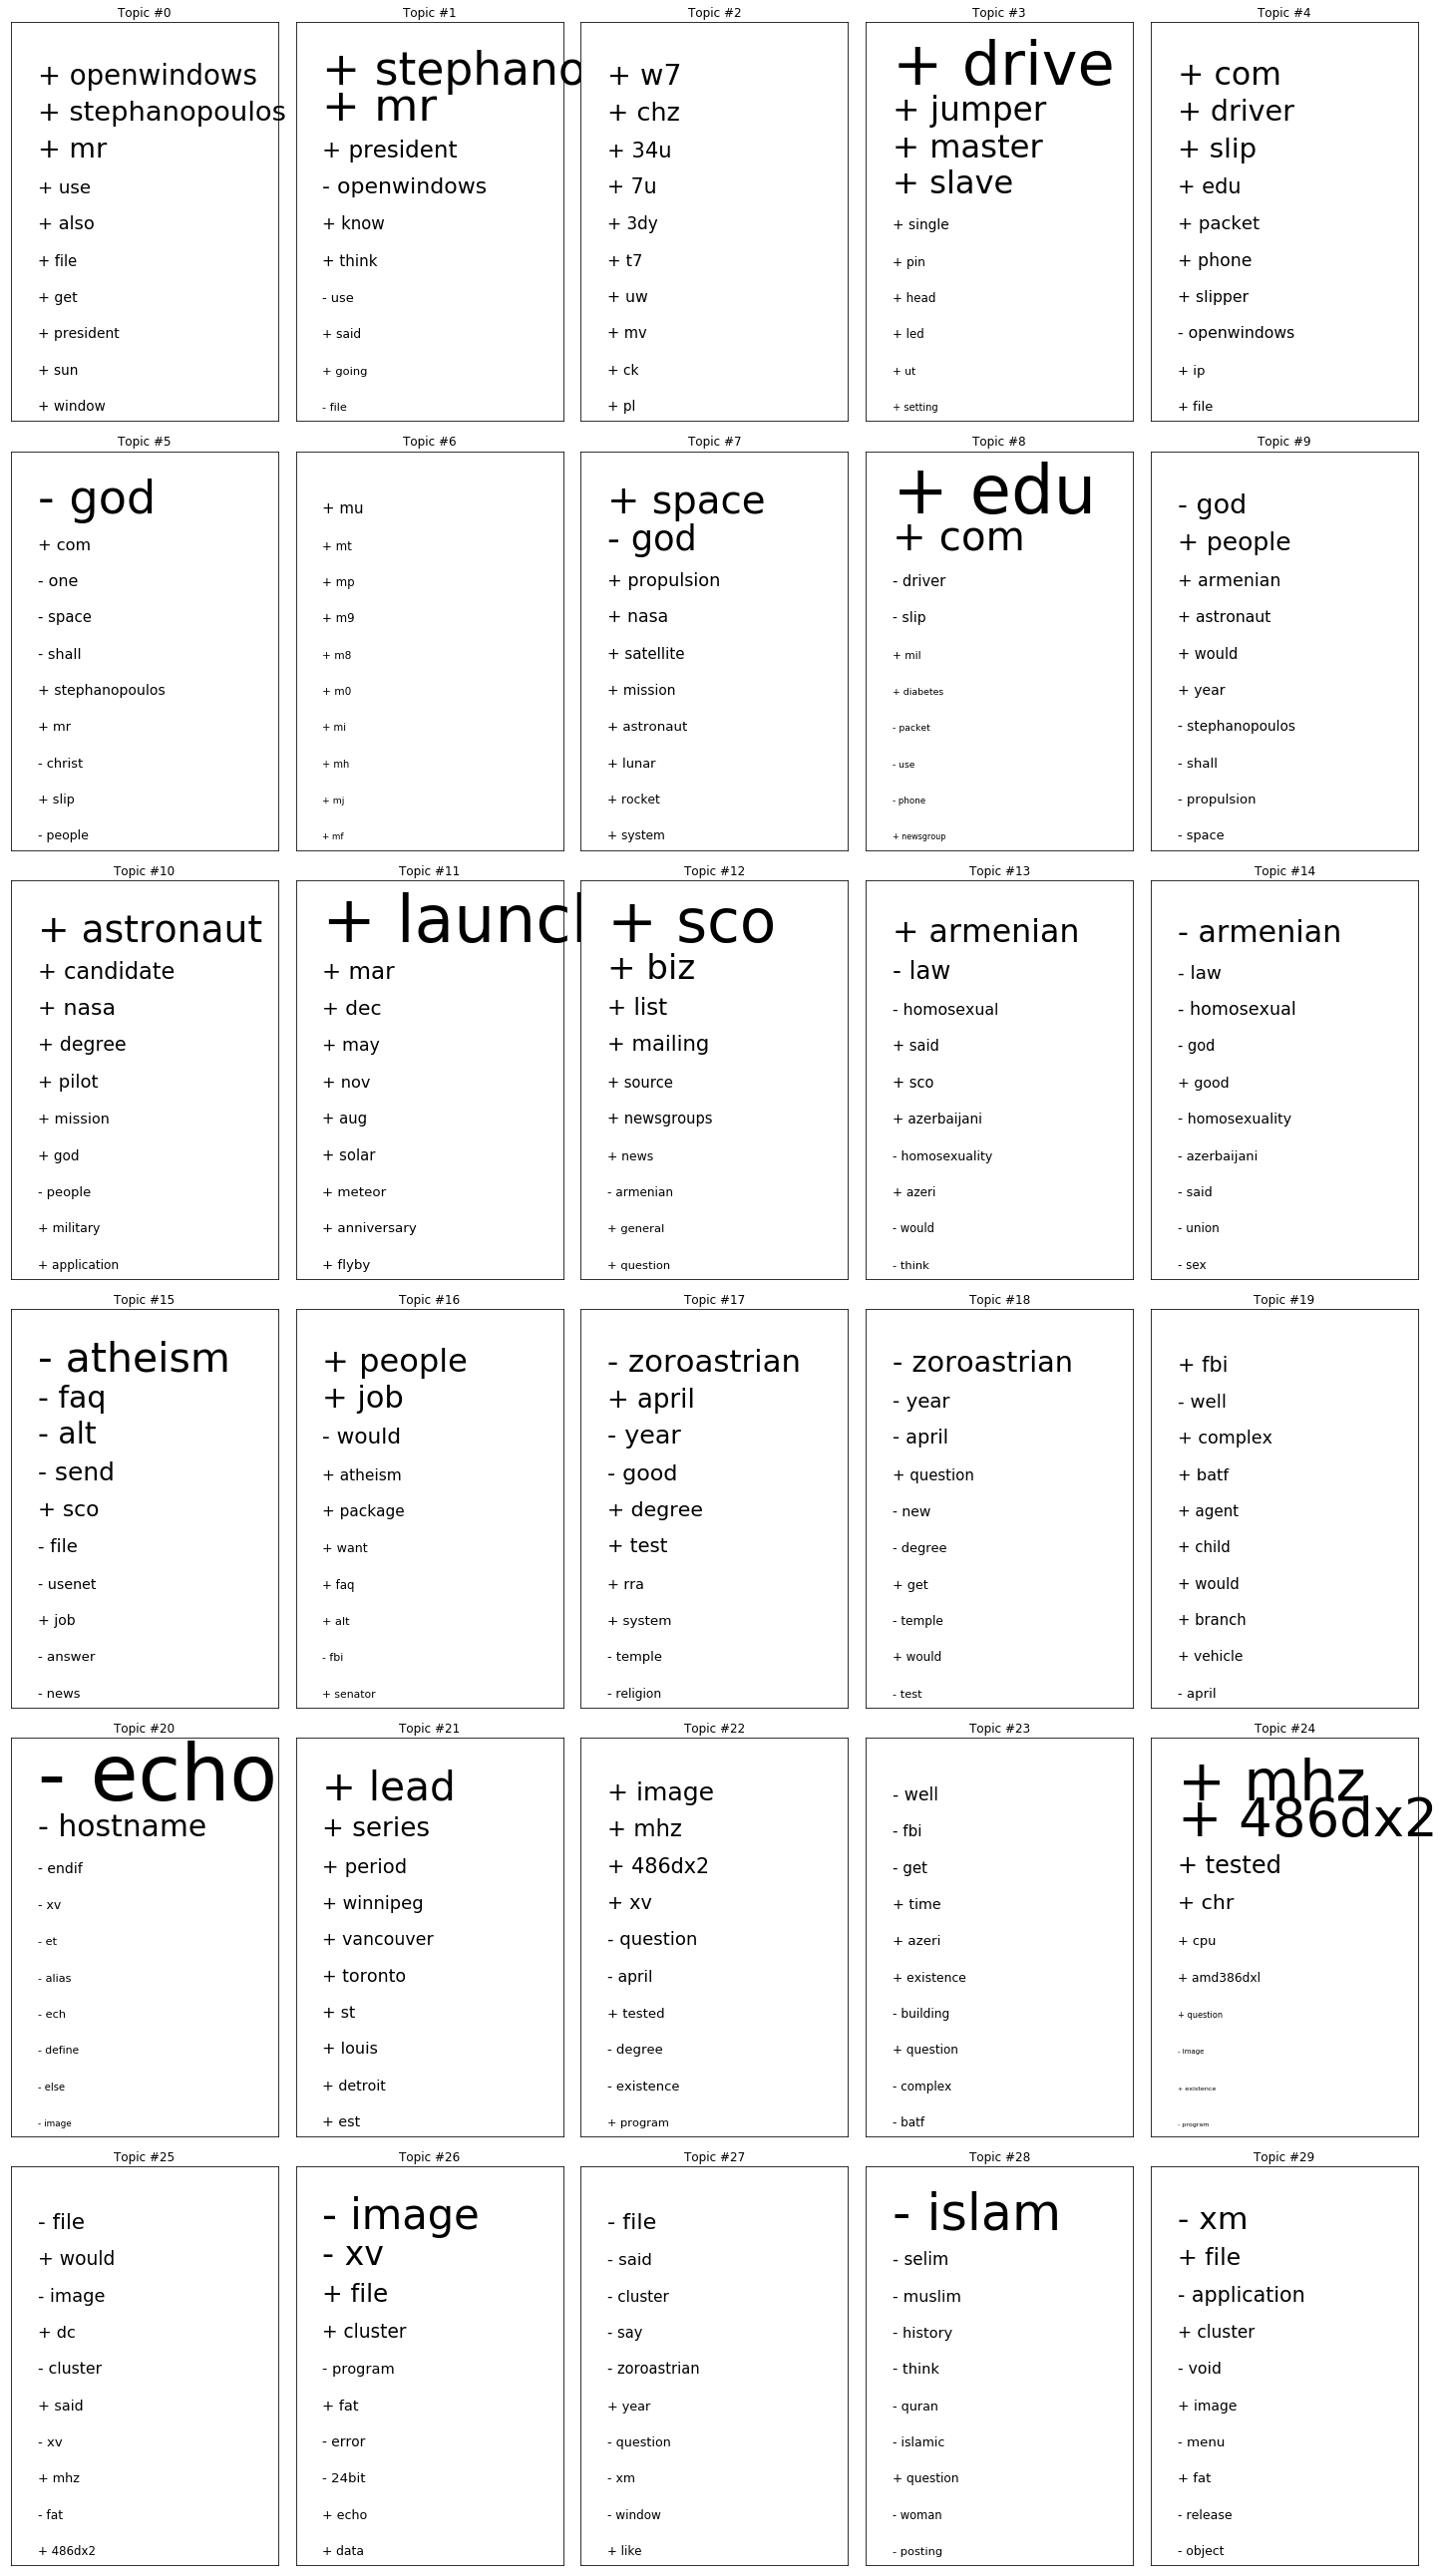

In [16]:
plot_topicwords(10, topic_words, 20, 36, 100)

#### Visualize topic shares using stack bar for LSI
After plotting the stack bar for LSI, we can see that the topic shares of each document differs any others.  

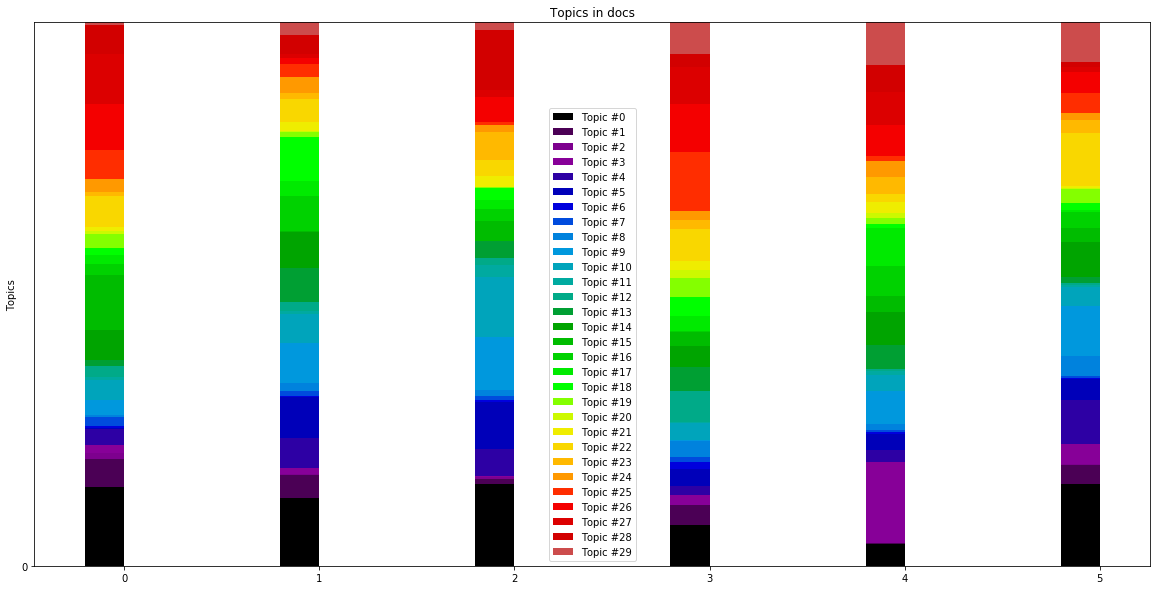

In [19]:
plot_topic_share(corpus_lsi[:6], topic_num, 20, 10)

#### Visualize topic shares using Heatmap for LSI
After plotting the Heatmap for LSI, we can see that the topic shares of each document differs any others.

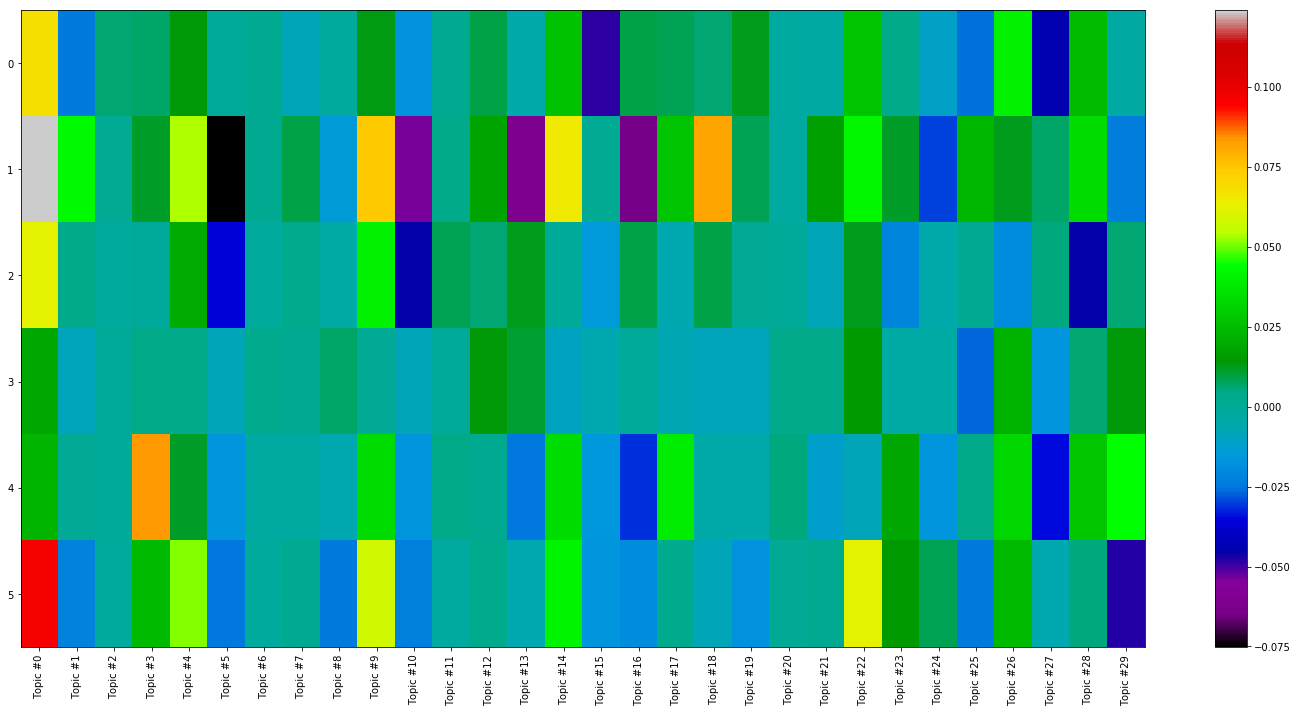

In [20]:
plot_topic_val(corpus_lsi[:6], topic_num, 20, 10)

## Training LDA model
We can also use the Gensim's LdaModel to train a LDA model. 
We have to construct a LsiModel object using gensim.models.ldamodel.LdaModel:

Parameters:

+ corpus: corpus used to generate topic model
+ num_topics: number of assuming topics
+ id2word: ID to word mapping
+ passes: times of passes over the supplied corpus
+ minimum_probability: choose to be small since I don't want to ignore some small-value topics. (which might cause trouble when visualizing topic shares in documents)

In [21]:
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix_sample, num_topics=topic_num, 
               id2word = dictionary_sample, passes=50, minimum_probability = 0.0001)

And we also get the significant words in each topics using the built-in function show_topics. (unlike LSI, LDA have to input number of topics, otherwise it just output top-10 topics) <br>
And we also get the distribution of topics in each documents via the get_document_topics method.

In [22]:
topic_words_lda = ldamodel.show_topics(num_topics=topic_num, formatted=False)
corpus_lda = ldamodel.get_document_topics(corpus_tfidf, minimum_phi_value=1e-10)

#### Visualize top words of topics for LDA
By visualizing the top words of topics from LDA model, we can easily find out:
+ Topic #0 might be related with test. 
+ Topic #1 might be related with religion.
+ Topic #2 might be related with game.
+ Topic #10 might be related with book.
+ Topic #26 might be related with space.
+ Topic #25 might be related with computer.
+ Topic #28 might be related with people.
+ Topic #29 might be related with sex.

...<br>
We can say there are more making sense topics than LSI.

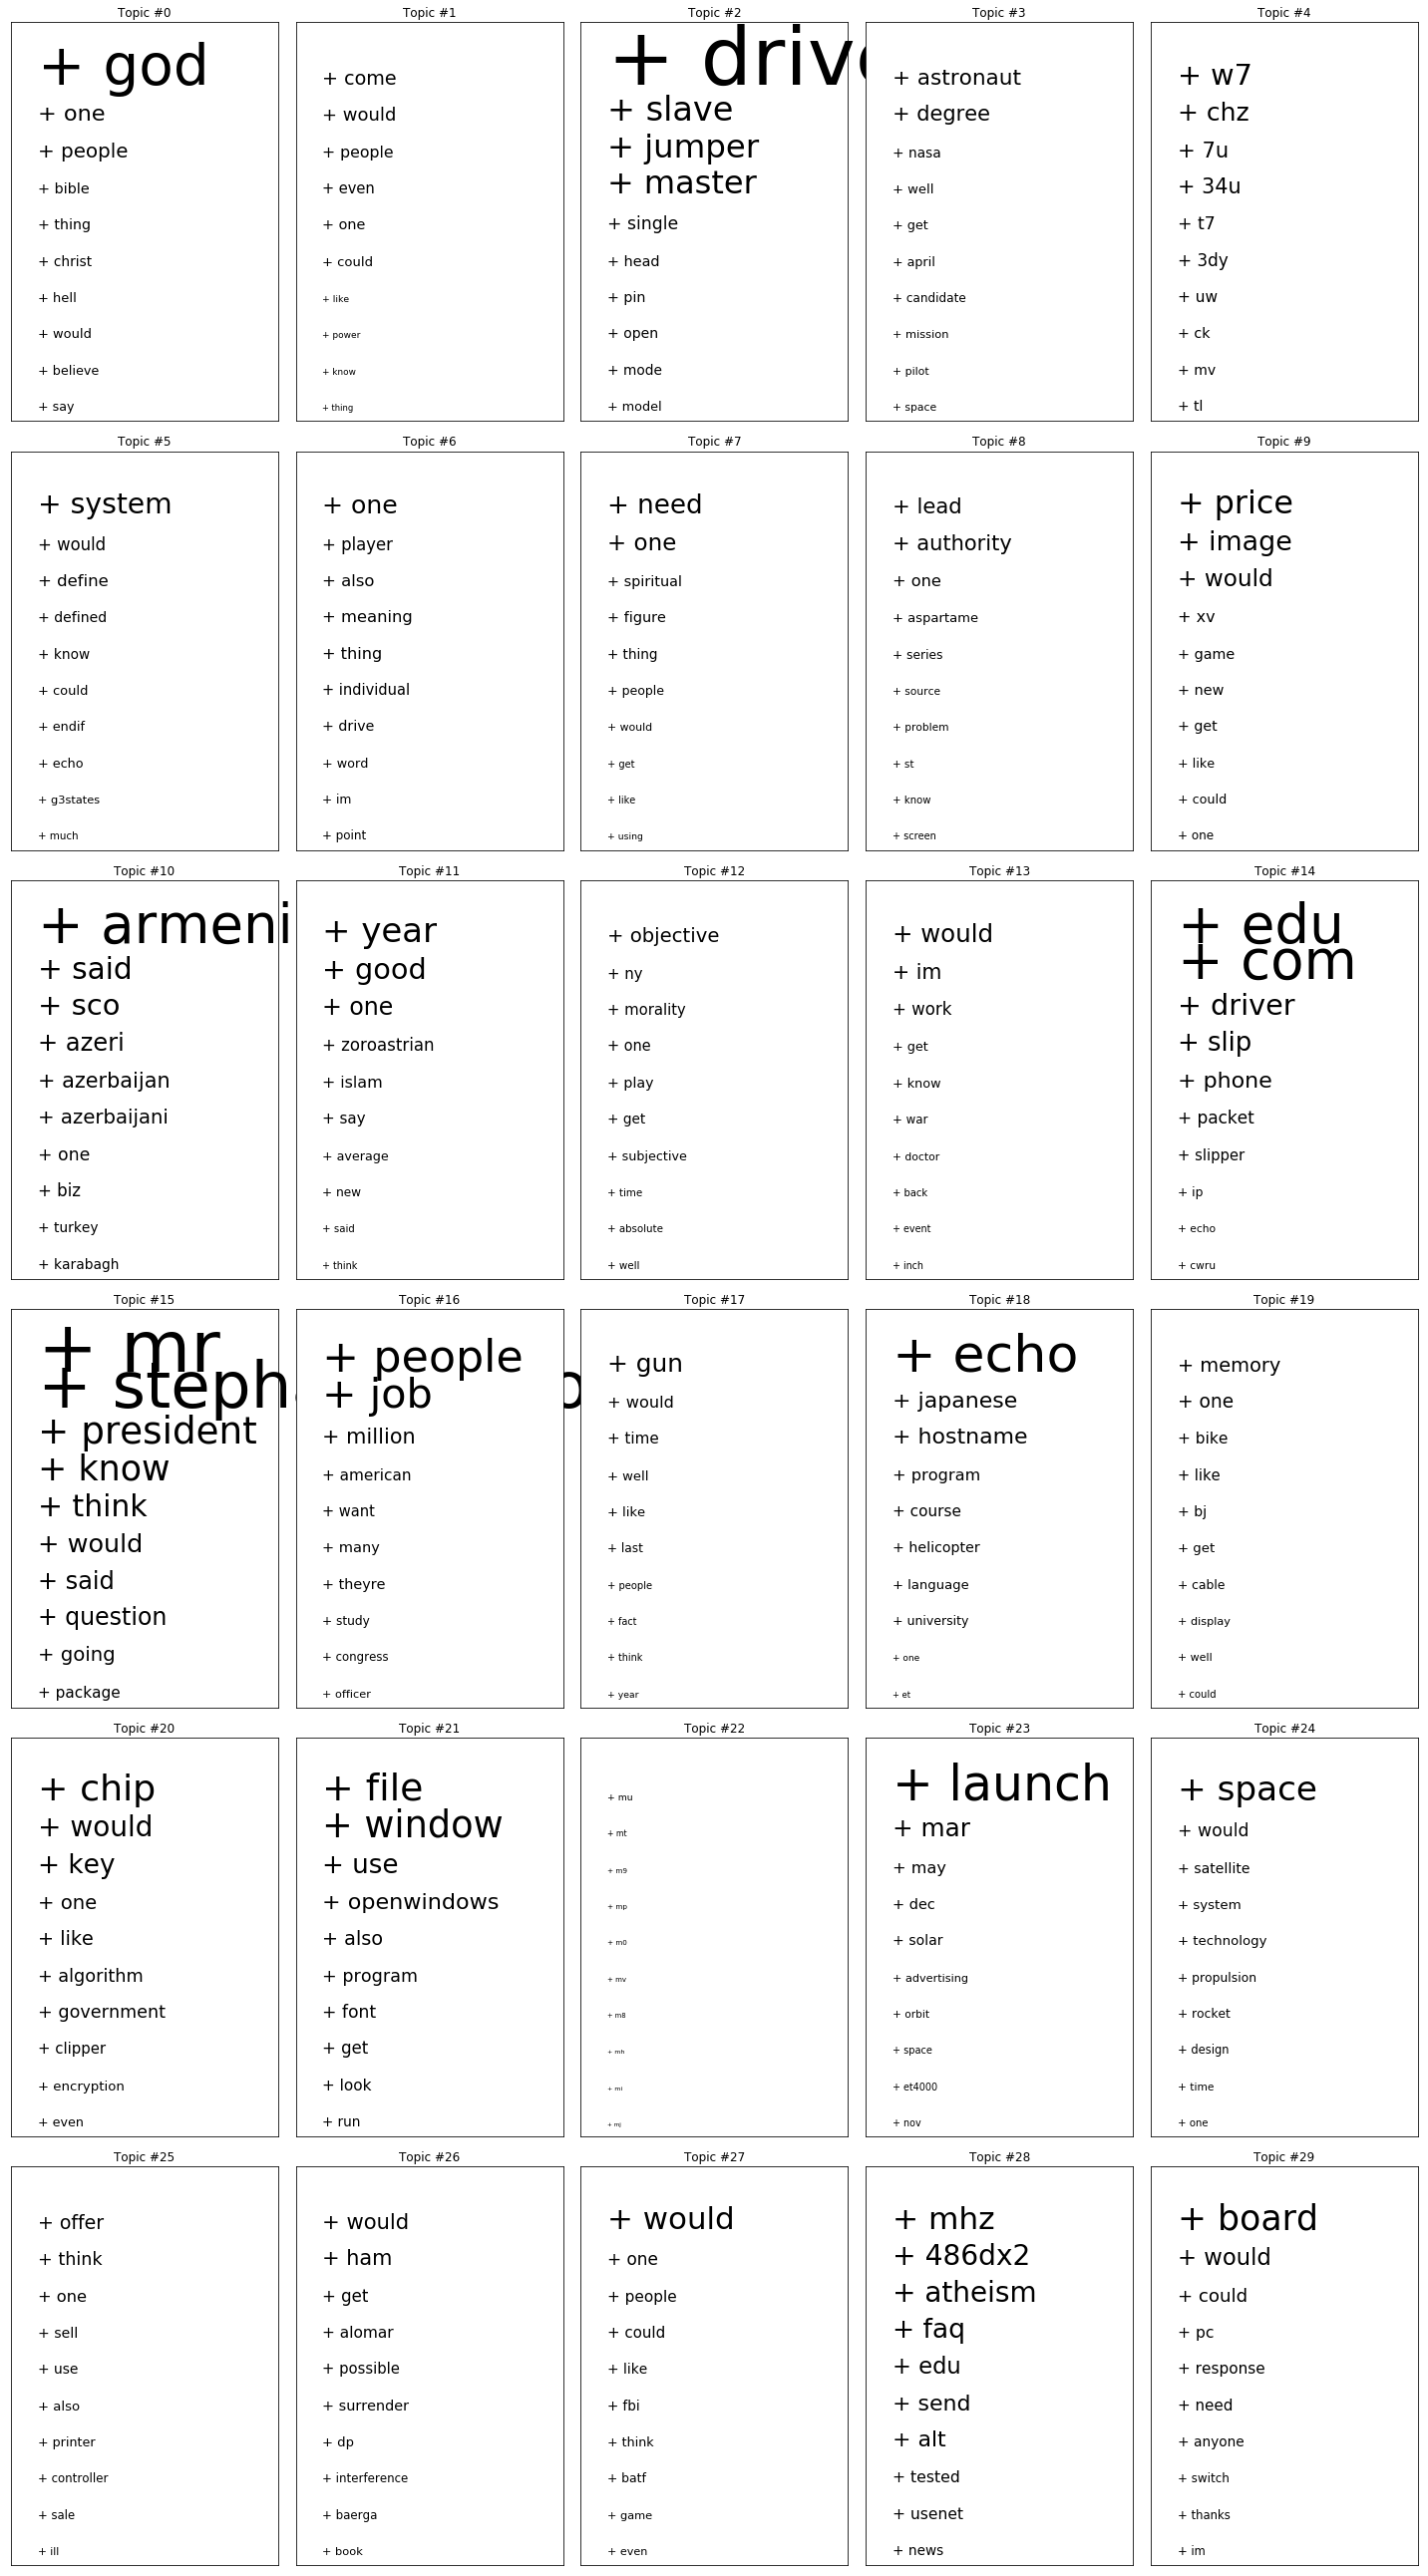

In [23]:
plot_topicwords(10, topic_words_lda, 20, 36, 2500)

#### Visualize topic shares using stack bar for LDA
After plotting the stack bar for LDA, we can see that the topic shares differs much. We can clearly point out the dominating topic in each document.

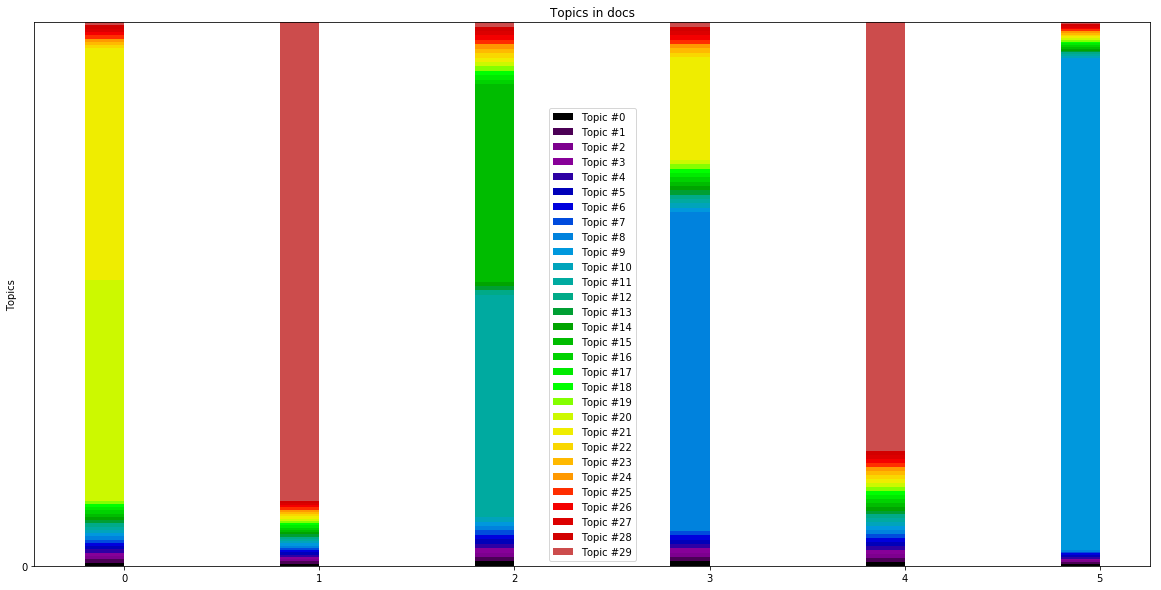

In [26]:
plot_topic_share(corpus_lda[:6], topic_num, 20, 10)

#### Visualize topic shares using Heatmap for LDA
We can clearly point out the dominating topic(s) in each document.

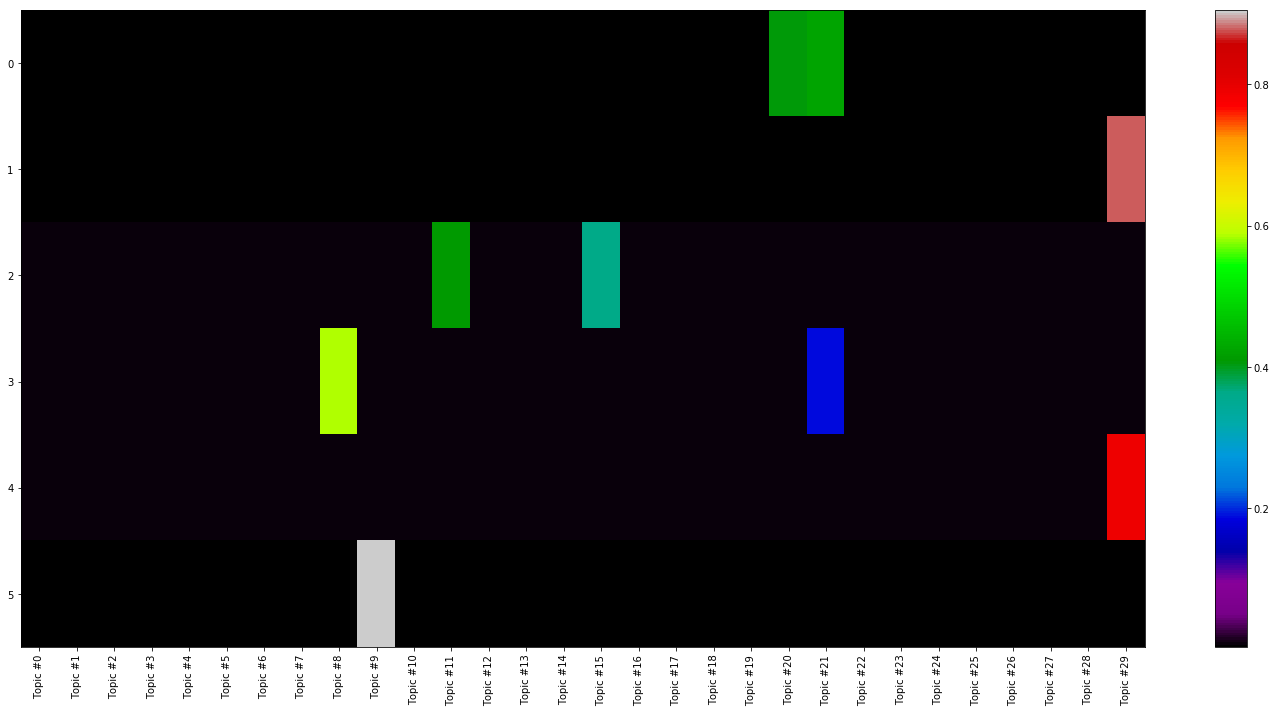

In [28]:
plot_topic_val(corpus_lda[:6], topic_num, 20, 10)

### Comparation

With the help of the result figures above, we can see clearly that the LDA model can get a more specific instead of diverse topic distribution. The domain topics in LDA model are easier to identify. Also the topic clusters of LDA model make more sense than LSI model. <br>
In summary, the LDA model outperforms tha LSI model. In sections below, we use **LDA model** to do all the topic model related task. 

## Finding structures of unknown text
As shown in [Training LDA model and visualizing](#Training-LDA-model-and-visualizing), we use an unknown data set to train the LDA model and get the topic distribution of each document in the data set. Then by summarying each topic's top words, we can figure it out the approximate meaning of each topic. In this way, we can find out the structure of each unknown document. <br>
Here we take the sample model as example. (**Remember: since I randomly select 1000 documents from the dataset, each time the running result may be totally different.** *Here I just take one time's result as an example.*)<br>
From [LDA heatmap figure](#Visualize-topic-shares-using-Heatmap-for-LDA), we know the first sample document is mainly about topic-20 and topic-21. Seen from the [top-word figure](#Visualize-top-words-of-topics-for-LDA), we can make a vague conclusion that the topic-20 and topic-21 are both computer related topics. And after we print out the document text below, we find out the document is indeed computer related, which means we can use topic model to find out the structure of unknown text. We can also test our observation by printing out the groung-truth category of this document

In [44]:
## print out the raw data of the first sample
print(data[sample_idxs[0]])

Hello,

I was wondering if anyone knew of an interface to od ( octal dump ), I assume
it would be called xod.  Actually, any viewer for a core file will do.

I looked at export ( @ mit ) in the index of /contrib, but didn't find anything 
relevant.



In [49]:
## Print out the ground truth of the first sample's category
print(categories[data_category[sample_idxs[0]]])

comp.windows.x


## Classifying unlabeled data
Now we have already known how to use topic model to find structure for unknown text set. We can go further to do classification for those unknown/unlabel data. <br>
We can use each document's topic distribution to generate features. And then we use kmeans to do clustering to do the classification. Finall we use the ground-truth category to get the precision and recall of the classification result.

In [68]:
def feature_generator_unlabeled(corpus_model):
    """
    docs_topic: gensim.interfaces.TransformedCorpus
    return: np array of each document's probability over 30 topics
    """
    feature_ls = [[item[1] for item in docs_topic] for docs_topic in corpus_model]
    return np.array(feature_ls)

In [169]:
feature = feature_generator_unlabeled(corpus_lda)

In [97]:
from sklearn.cluster import KMeans
cluster_num = 20
kmeans = KMeans(n_clusters = cluster_num, random_state=0).fit(feature)

In [166]:
# get the kmeans cluster labels of each document
predict_category = kmeans.labels_

In [167]:
# get the sample data's ground-truth category
sample_category = []
for idx in sample_idxs:
    sample_category.append(data_category[idx])

In [264]:
# get the confusion matrix
def get_confusion_mat(predict, truth):
    confusion_mat = [[0 for i in range(len(categories))] for j in range(cluster_num)] 
    for idx, val in enumerate(predict):
        true_val = truth[idx]
        confusion_mat[true_val][val] += 1
    res = np.array(confusion_mat)
    return res


In order to better show the result, here I use confusion matrix to respresent and use heatmap to visualize it. Since the cluster index is not coordinate with the category index, the confusion matrix is not a normal one. 

In [265]:
confusion_mat = get_confusion_mat(predict_category, sample_category)

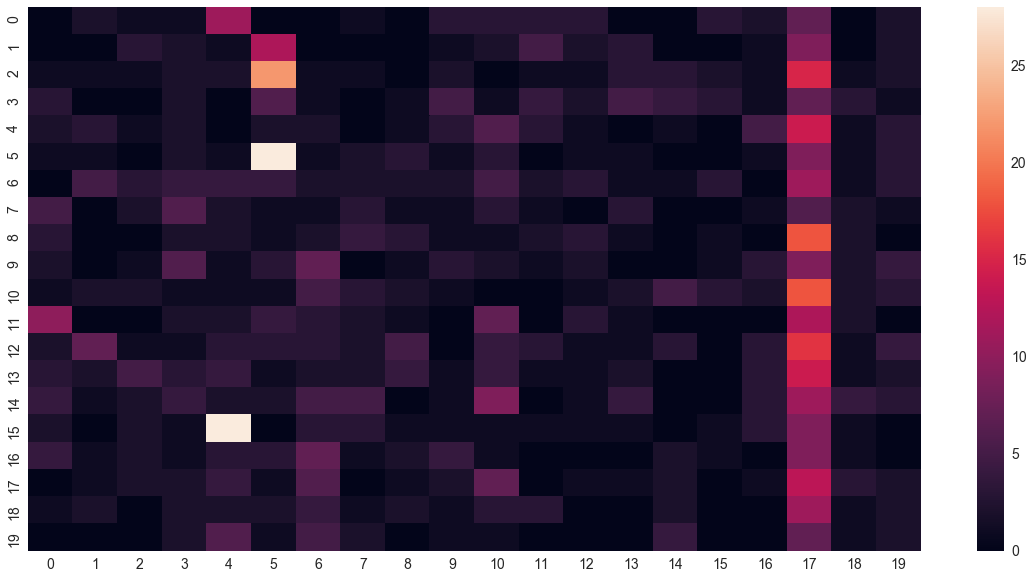

In [266]:
# Use the seaborn library to quickly plot the confusion matrix
def plot_confusion(mat):
    import seaborn as sn
    ax = sn.heatmap(mat)
    plt.show()
plot_confusion(confusion_mat)

Since the index of each cluster in Kmeans is not the same as the index of ground-truth category, here we just consider the one with most appearance. And use that assumption to get the precision and recall.

In [267]:
## Get the precision using the confusion matrix
def get_precision(confusion):
    return confusion.max(axis=0).sum()/confusion.sum()

print("The precision of the classification is: " + str(get_precision(confusion_mat)))

The precision of the classification is: 0.167


In [268]:
# Get the recall using the confusion matrix
def get_recall(confusion):
    return confusion.max(axis=1).sum()/confusion.sum()

print("The recall of the classification is: " + str(get_recall(confusion_mat)))

The recall of the classification is: 0.277


We can see that the precision and recall of the result is not good. That's because it is the unsurpervised learning and we barely know anything about the dataset at all. <br>
The bad performance of the classification might also result from:
+ the small topic number we choose. So I test using 100 topic number.
+ the small dataset we choose. So here I test in the whole dataset.

### Larger topic number
Here I set the topic number to be 100 instead of 20 and repeat the above code. Get the precision and recall. <br>
We can see that the recall improved significantly. *(From 0.28 to 0.72)* However, the precision decreases. That might be caused by the small dataset we use.

In [208]:
# Running and Trainign LDA model on the document term matrix.
topic_num2 = 100
ldamodel2 = Lda(doc_term_matrix_sample, num_topics=topic_num2, 
               id2word = dictionary_sample, passes=50, minimum_probability = 0.0001)

topic_words_lda2 = ldamodel2.show_topics(num_topics=topic_num2, formatted=False)
corpus_lda2 = ldamodel2.get_document_topics(corpus_tfidf, minimum_phi_value=1e-10)

feature2 = feature_generator_unlabeled(corpus_lda2)

kmeans2 = KMeans(n_clusters = cluster_num, random_state=0).fit(feature2)

# get the kmeans cluster labels of each document
predict_category2 = kmeans2.labels_


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/gensim/models/ldamodel.py:775: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


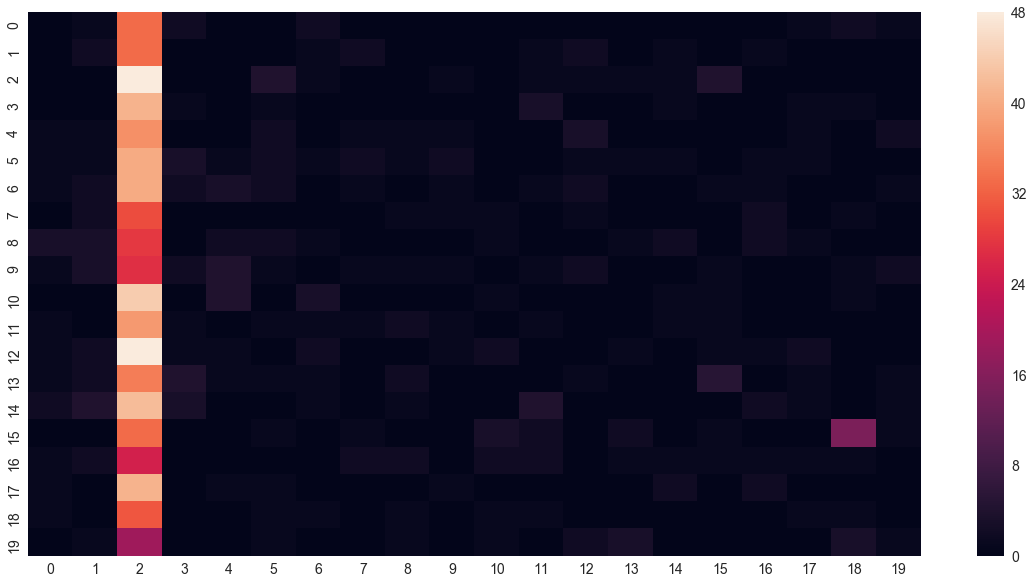

In [269]:
confusion_mat2 = get_confusion_mat(predict_category2, sample_category)
plot_confusion(confusion_mat2)

In [270]:
print("The precision of the classification is: " + str(get_precision(confusion_mat2)))

print("The recall of the classification is: " + str(get_recall(confusion_mat2)))

The precision of the classification is: 0.117
The recall of the classification is: 0.713


### Larger dataset
Here I use the whole dataset instead of the random sample one. Get the precision and recall. <br>
We can see that both precision and recall are improved significantly *(precision from 0.17 to 0.35, recall from 0.28 to 0.43)*. That means if we use larger dataset to generate topic model and do classification, we can get better result. <br>

In [ ]:
## Run LDA in larger(whole) dataset 
# Running and Trainign LDA model on the document term matrix.
ldamodel_all = Lda(doc_term_matrix_all, num_topics=topic_num, 
               id2word = dictionary_all, passes=50, minimum_probability = 0.0001)

# Use tf-idf model to help get each document's topic
tfidf_all = gensim.models.TfidfModel(doc_term_matrix_all)
corpus_tfidf_all = tfidf[doc_term_matrix_all]

topic_words_lda_all = ldamodel_all.show_topics(num_topics=topic_num, formatted=False)
corpus_lda_all = ldamodel_all.get_document_topics(corpus_tfidf_all, minimum_phi_value=1e-10)

feature_all = feature_generator_unlabeled(corpus_lda_all)

kmeans_all = KMeans(n_clusters = cluster_num, random_state=0).fit(feature_all)

# get the kmeans cluster labels of each document
predict_category_all = kmeans_all.labels_



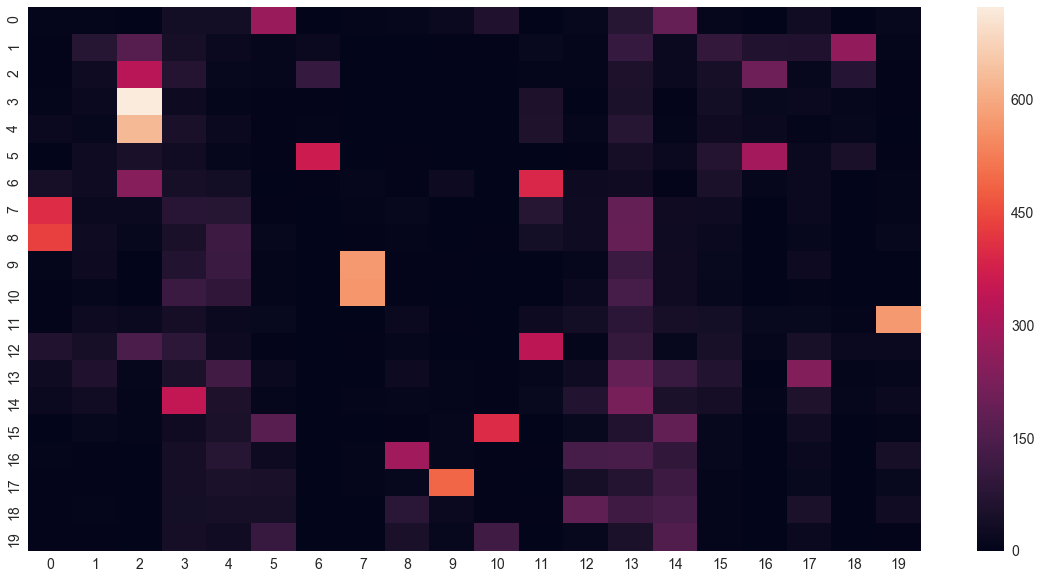

In [271]:
confusion_mat_all = get_confusion_mat(predict_category_all, data_category)
plot_confusion(confusion_mat_all)

In [272]:
print("The precision of the classification is: " + str(get_precision(confusion_mat_all)))

print("The recall of the classification is: " + str(get_recall(confusion_mat_all)))

The precision of the classification is: 0.3473946726095723
The recall of the classification is: 0.42231773320598537


### Summary
In all, if a unlabeled dataset is large enough, we can use topic model to do brief classification. The result might not be that good, but it is enough for unknown dataset, especific multiclass dataset. 

## Classifying labeled data
If we have a labeled dataset, we can also use topic model to improve the classification accuracy. <br>
Here I use SVM linear kernel to train a model. Divide the whole dataset into training and testing part. Use the topic model to build the feature just as we did in [Classifying unlabeled data](#Classifying-unlabeled-data). And then get the confusion matrix as well as the precision and recall.<br>
We can see from the result that both the precision and the recall get improved significantly. The nearly 50% accuracy is pretty good for multiclass classification.  

In [259]:
# training a linear SVM classifier
import sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(feature_all, data_category, random_state = 0)

svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train)
svm_predictions = svm_model_linear.predict(X_test)
 
# creating a confusion matrix
cm = confusion_matrix(y_test, svm_predictions)

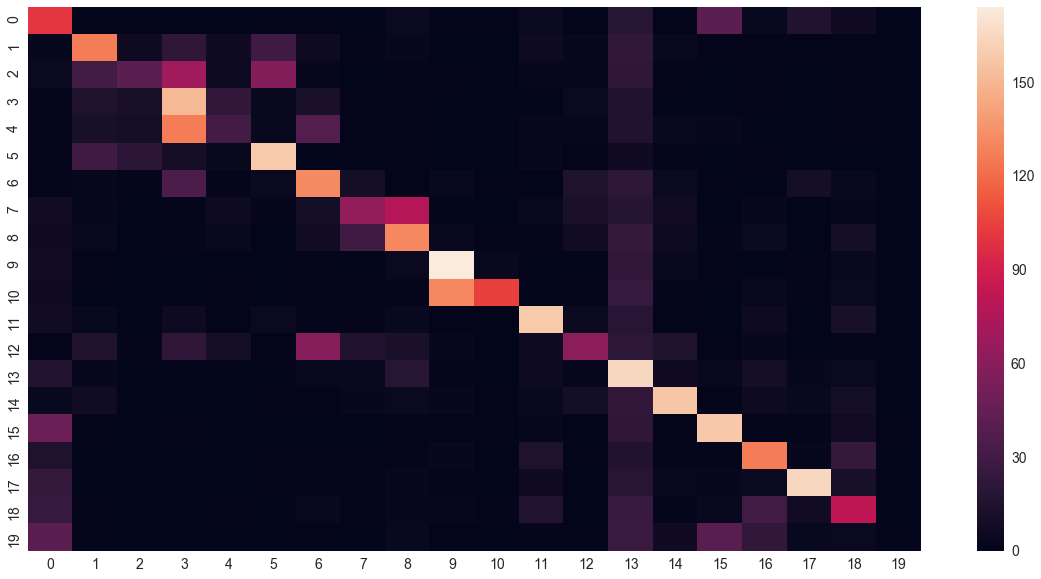

In [262]:
plot_confusion(cm)

In [273]:
print("The precision of the classification is: " + str(get_precision(cm)))

print("The recall of the classification is: " + str(get_recall(cm)))

The precision of the classification is: 0.4864176570458404
The recall of the classification is: 0.5297113752122241


## Conclusion

In [276]:
def learn_classifier(X_train, y_train, kernel):
    clf = sklearn.svm.SVC(kernel=kernel)
    return clf.fit(X_train, y_train)

In [278]:
def evaluate_classifier(classifier, X_validation, y_validation):
    y_predict = classifier.predict(X_validation)
    return sklearn.metrics.accuracy_score(y_validation, y_predict)

In [279]:
for kernel in ['linear', 'rbf', 'poly', 'sigmoid']:
    classifier = learn_classifier(X_train, y_train, kernel)
    accuracy = evaluate_classifier(classifier, X_test, y_test)
    print(kernel,':',accuracy)

linear : 0.4864176570458404
rbf : 0.432937181663837
poly : 0.04647707979626486
sigmoid : 0.4051358234295416


In [274]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(feature_all, data_category, random_state = 0)

svm_model_linear2 = SVC(kernel = 'linear', C = 1).fit(X_train2, y_train2)
svm_predictions2 = svm_model_linear2.predict(X_test2)
 
# creating a confusion matrix
cm2 = confusion_matrix(y_test2, svm_predictions2)

In [275]:
print("The precision of the classification is: " + str(get_precision(cm2)))
print("The recall of the classification is: " + str(get_recall(cm2)))

The precision of the classification is: 0.5280135823429541
The recall of the classification is: 0.5382003395585738


In [250]:
## Run LDA in larger(whole) dataset 
# Running and Trainign LDA model on the document term matrix.
ldamodel_all2 = Lda(doc_term_matrix_all, num_topics=topic_num2, 
               id2word = dictionary_all, passes=50, minimum_probability = 0.0001)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/gensim/models/ldamodel.py:775: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [255]:
topic_words_lda_all2 = ldamodel_all2.show_topics(num_topics=topic_num2, formatted=False)
corpus_lda_all2 = ldamodel_all2.get_document_topics(corpus_tfidf_all, minimum_phi_value=1e-10)

feature_all2 = feature_generator_unlabeled(corpus_lda_all2)

kmeans_all2 = KMeans(n_clusters = cluster_num, random_state=0).fit(feature_all2)

# get the kmeans cluster labels of each document
predict_category_all2 = kmeans_all2.labels_

confusion_mat_all2 = get_confusion_mat(predict_category_all2, data_category)

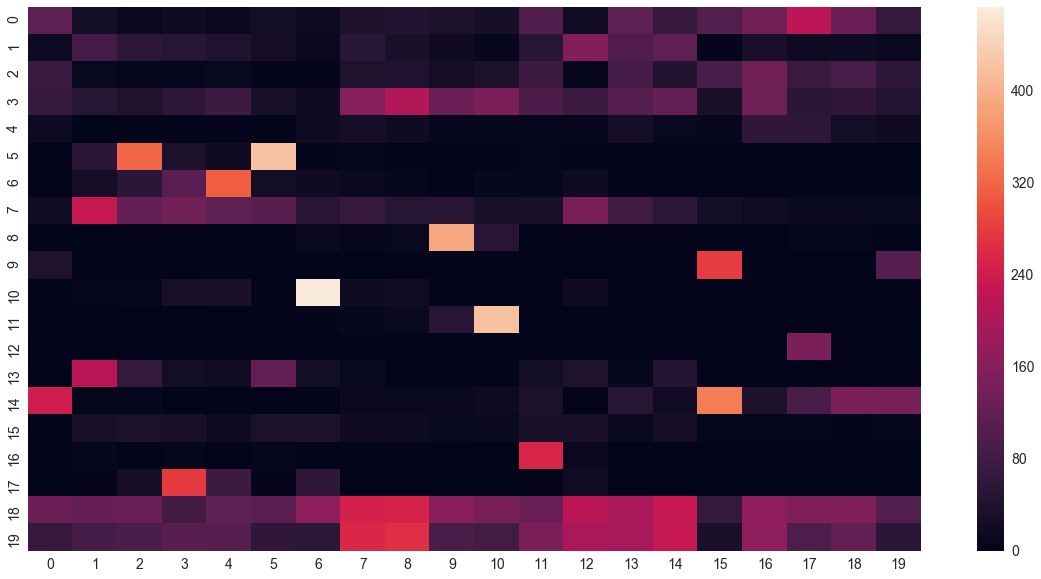

In [256]:
plot_confusion(confusion_mat_all2)

In [257]:
print("The precision of the classification is: " + str(get_precision(confusion_mat_all2)))
print("The recall of the classification is: " + str(get_recall(confusion_mat_all2)))

The precision of the classification is: 0.27050833068025043
The recall of the classification is: 0.2938554600445718
